Install and import packages

In [2]:
!pip install python-dotenv
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV
import pickle
import optuna
from xgboost import XGBClassifier

Define the global variable

In [4]:
PATH = '/content/drive/MyDrive/Brave_Career/'

Load data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
dataset = pd.read_csv(PATH + "Stock_data.csv")
dataset.head()

,year,adjDividend,dps_growth,dps_growth_rate,industry,sector,interestRate,interestRate_percentage_change,symbol,currentRatio,...,priceEarningsToGrowthRatio_percentage_change,priceSalesRatio,priceSalesRatio_percentage_change,dividendYield,dividendYield_percentage_change,enterpriseValueMultiple,enterpriseValueMultiple_percentage_change,priceFairValue,priceFairValue_percentage_change,dps_change_next_year
0,2013,2.54,0.18,7.627119,Conglomerates,Industrials,0.11,-21.428571,MMM,1.698186,...,21.912892,2.590120,43.788017,0.021636,-28.717284,10.375463,41.488241,4.455070,49.198542,constant/increased
1,2014,3.42,0.88,34.645669,Conglomerates,Industrials,0.09,-18.181818,MMM,1.961487,...,-39.853265,2.802775,8.210229,0.024847,14.839742,11.018038,6.193217,6.786417,52.330210,constant/increased
2,2015,4.10,0.68,19.883041,Conglomerates,Industrials,0.13,44.444444,MMM,1.543411,...,709.657256,2.602706,-7.138241,0.032502,30.811804,10.475280,-4.926085,6.707612,-1.161218,constant/increased
3,2016,4.44,0.34,8.292683,Conglomerates,Industrials,0.40,207.692308,MMM,1.885512,...,-82.081834,2.998496,15.206860,0.029663,-8.736708,11.444603,9.253432,8.728774,30.132361,constant/increased
4,2017,4.70,0.26,5.855856,Conglomerates,Industrials,1.00,150.000000,MMM,1.857292,...,-512.145931,3.714250,23.870455,0.023839,-19.634183,13.720421,19.885518,10.117194,15.906239,constant/increased


Focus on classification:

drop "dps_growth_absolute" and 'next_year_dividend' from source columns

keep one target column "dps_change_next_year"

In [ ]:
# dataset.drop(["dps_growth_absolute", "next_year_dividend", "sector_ranking", "industry_ranking"], axis="columns", inplace=True)

In [7]:
dataset.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4790 entries, 0 to 4789
Data columns (total 118 columns):
 #    Column                                                Dtype  
---   ------                                                -----  
 0    year                                                  int64  
 1    adjDividend                                           float64
 2    dps_growth                                            float64
 3    dps_growth_rate                                       float64
 4    industry                                              object 
 5    sector                                                object 
 6    interestRate                                          float64
 7    interestRate_percentage_change                        float64
 8    symbol                                                object 
 9    currentRatio                                          float64
 10   currentRatio_percentage_change                        float64
 11   qu

Correlation Matrix

In [8]:
# Select only numeric columns
numeric_dataset = dataset.select_dtypes(include=[float, int])

# Compute the correlation matrix
correlation_matrix = numeric_dataset.corr()

# save matrix to csv
correlation_matrix.to_csv(PATH + "correlation_matrix_bkp.csv")
print(correlation_matrix)

                                               year  adjDividend  dps_growth  \
year                                       1.000000     0.136872    0.011931   
adjDividend                                0.136872     1.000000    0.568020   
dps_growth                                 0.011931     0.568020    1.000000   
dps_growth_rate                           -0.020925     0.249702    0.296808   
interestRate                               0.481105     0.088946    0.019746   
...                                             ...          ...         ...   
dividendYield_percentage_change           -0.004355     0.065545    0.012130   
enterpriseValueMultiple                    0.029642     0.008925    0.001974   
enterpriseValueMultiple_percentage_change -0.022715     0.021671    0.006514   
priceFairValue                            -0.004393     0.006251    0.020014   
priceFairValue_percentage_change          -0.007429     0.044735    0.049398   

                                       

Remove highly correlated columns

In [9]:
def rank_columns_by_correlation(df, threshold=0.9):
    # Calculating correlation matrix
    corr_matrix = df.corr()
    # Initializing a list to hold the tuples (col1, col2, correlation)
    correlations = []
    # Iterating over the correlation matrix
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):  # avoiding duplicate and self-correlation
            # Including only correlations above the specified threshold
            if abs(corr_matrix.iloc[i, j]) > threshold:
                correlations.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

    # Sorting the list by absolute correlation in descending order
    sorted_correlations = sorted(correlations, key=lambda x: abs(x[2]), reverse=True)
    correlation_df = pd.DataFrame(sorted_correlations, columns=['Column1', 'Column2', 'Correlation'])
    return correlation_df

top_correlations = rank_columns_by_correlation(numeric_dataset, 0.98)

# Remove highly correlated columns
columns_to_remove = top_correlations["Column2"].unique()
dataset.drop(columns_to_remove, axis="columns", inplace=True)
dataset.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4790 entries, 0 to 4789
Data columns (total 93 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   year                                                  4790 non-null   int64  
 1   adjDividend                                           4790 non-null   float64
 2   dps_growth                                            4790 non-null   float64
 3   dps_growth_rate                                       4790 non-null   float64
 4   industry                                              4790 non-null   object 
 5   sector                                                4790 non-null   object 
 6   interestRate                                          4790 non-null   float64
 7   interestRate_percentage_change                        4790 non-null   float64
 8   symbol                                                4790

# Data Preprocessing

In [10]:
# Missing value
dataset.dropna(inplace=True)

# Test-train-validation Split

In [12]:
# 2022 testing data, 2021 validation data, 2013-2020 training data
training_data = dataset.loc[(dataset["year"] != 2022) & (dataset["year"] != 2021)]
validation_data = dataset.loc[dataset["year"] == 2021]
testing_data = dataset.loc[dataset["year"] == 2022]

In [13]:
# Predictor - Target Split
X_train = training_data.drop("dps_change_next_year", axis="columns")
y_train = training_data["dps_change_next_year"]
X_test = testing_data.drop("dps_change_next_year", axis="columns")
y_test = testing_data["dps_change_next_year"]
X_validate = validation_data.drop("dps_change_next_year", axis="columns")
y_validate = validation_data["dps_change_next_year"]

Encoding our categorical features

In [14]:
# Define categorical features
categorical_columns = ["industry", "sector", "symbol"]
other_columns = [col for col in X_train.columns if col not in categorical_columns]

# Label encode categorical features with many categories
column_transformer = ColumnTransformer(
    transformers=[
        ('categorical', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_columns)
    ],
    remainder='passthrough'
)

X_train_transformed = column_transformer.fit_transform(X_train)
X_validate_transformed = column_transformer.transform(X_validate)
X_test_transformed = column_transformer.transform(X_test)

# Note: after transformation, the output will be a numpy array and column orders will be changed.
X_train_transformed = pd.DataFrame(X_train_transformed, columns=categorical_columns + other_columns)
X_validate_transformed = pd.DataFrame(X_validate_transformed, columns=categorical_columns + other_columns)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=categorical_columns + other_columns)

X_train_transformed.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3832 entries, 0 to 3831
Data columns (total 92 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   industry                                              3832 non-null   float64
 1   sector                                                3832 non-null   float64
 2   symbol                                                3832 non-null   float64
 3   year                                                  3832 non-null   float64
 4   adjDividend                                           3832 non-null   float64
 5   dps_growth                                            3832 non-null   float64
 6   dps_growth_rate                                       3832 non-null   float64
 7   interestRate                                          3832 non-null   float64
 8   interestRate_percentage_change                        3832

In [15]:
# Let's change our data types back to their original forms - However, this time, categorical variables have become
# number like strings
cols_to_convert = {'industry': 'str', 'sector': 'str', 'symbol': 'str', 'year': 'int'}
X_train_transformed = X_train_transformed.astype(cols_to_convert)
X_validate_transformed = X_validate_transformed.astype(cols_to_convert)
X_test_transformed = X_test_transformed.astype(cols_to_convert)


# Check data imbalance
# Let's add target back to our dataset for further analysis
training_data_transformed = pd.concat([X_train_transformed, y_train], axis=1)
training_data_transformed["dps_change_next_year"].value_counts()

dps_change_next_year
constant/increased    3618
decreased              214
Name: count, dtype: int64

# Over Sampling

In [16]:
# Perform oversampling using SMOTE
categorical_indices = [X_train_transformed.columns.get_loc(col) for col in categorical_columns]
smote = SMOTENC(random_state=1, categorical_features=categorical_indices)

X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train_transformed, y_train)

# Check our training data
pd.DataFrame(y_train_oversampled)["dps_change_next_year"].value_counts()

dps_change_next_year
constant/increased    3618
decreased             3618
Name: count, dtype: int64

In [17]:
X_train_oversampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7236 entries, 0 to 7235
Data columns (total 92 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   industry                                              7236 non-null   object 
 1   sector                                                7236 non-null   object 
 2   symbol                                                7236 non-null   object 
 3   year                                                  7236 non-null   int64  
 4   adjDividend                                           7236 non-null   float64
 5   dps_growth                                            7236 non-null   float64
 6   dps_growth_rate                                       7236 non-null   float64
 7   interestRate                                          7236 non-null   float64
 8   interestRate_percentage_change                        7236

# Feature Selection

In [28]:
# Feature importance analysis - Tree Based
randomForestModel = RandomForestClassifier(max_features=None)  # We want all features to be considered for each tree
randomForestModel.fit(X_train_oversampled, y_train_oversampled)
model_importance = randomForestModel.feature_importances_
importance_table = pd.DataFrame(columns=["Feature", "Importance"])  # Create an importance table to plot bar chart
featureNum = 0
for score in model_importance:
    print("feature " + str(featureNum) + "'s importance score: " + str(score) + " (" + X_train_oversampled.columns[featureNum] + ")")
    rowAdded = pd.DataFrame([[X_train_oversampled.columns[featureNum], score]], columns=["Feature", "Importance"])
    importance_table = pd.concat([importance_table, rowAdded])
    featureNum = featureNum + 1
importance_table.sort_values('Importance', inplace=True, ascending=False)

feature 0's importance score: 0.004172791042655142 (industry)
feature 1's importance score: 0.004813868966515316 (sector)
feature 2's importance score: 0.002715236489282257 (symbol)
feature 3's importance score: 0.03830380197326386 (year)
feature 4's importance score: 0.021699992786635605 (adjDividend)
feature 5's importance score: 0.2672527540474256 (dps_growth)
feature 6's importance score: 0.06594162704155647 (dps_growth_rate)
feature 7's importance score: 0.12515568144286926 (interestRate)
feature 8's importance score: 0.06323833775163422 (interestRate_percentage_change)
feature 9's importance score: 0.004280170725598122 (currentRatio)
feature 10's importance score: 0.00227001004788315 (currentRatio_percentage_change)
feature 11's importance score: 0.005031265390425709 (quickRatio)
feature 12's importance score: 0.0040183153038292905 (daysOfSalesOutstanding)
feature 13's importance score: 0.005895799398318912 (daysOfSalesOutstanding_percentage_change)
feature 14's importance score:

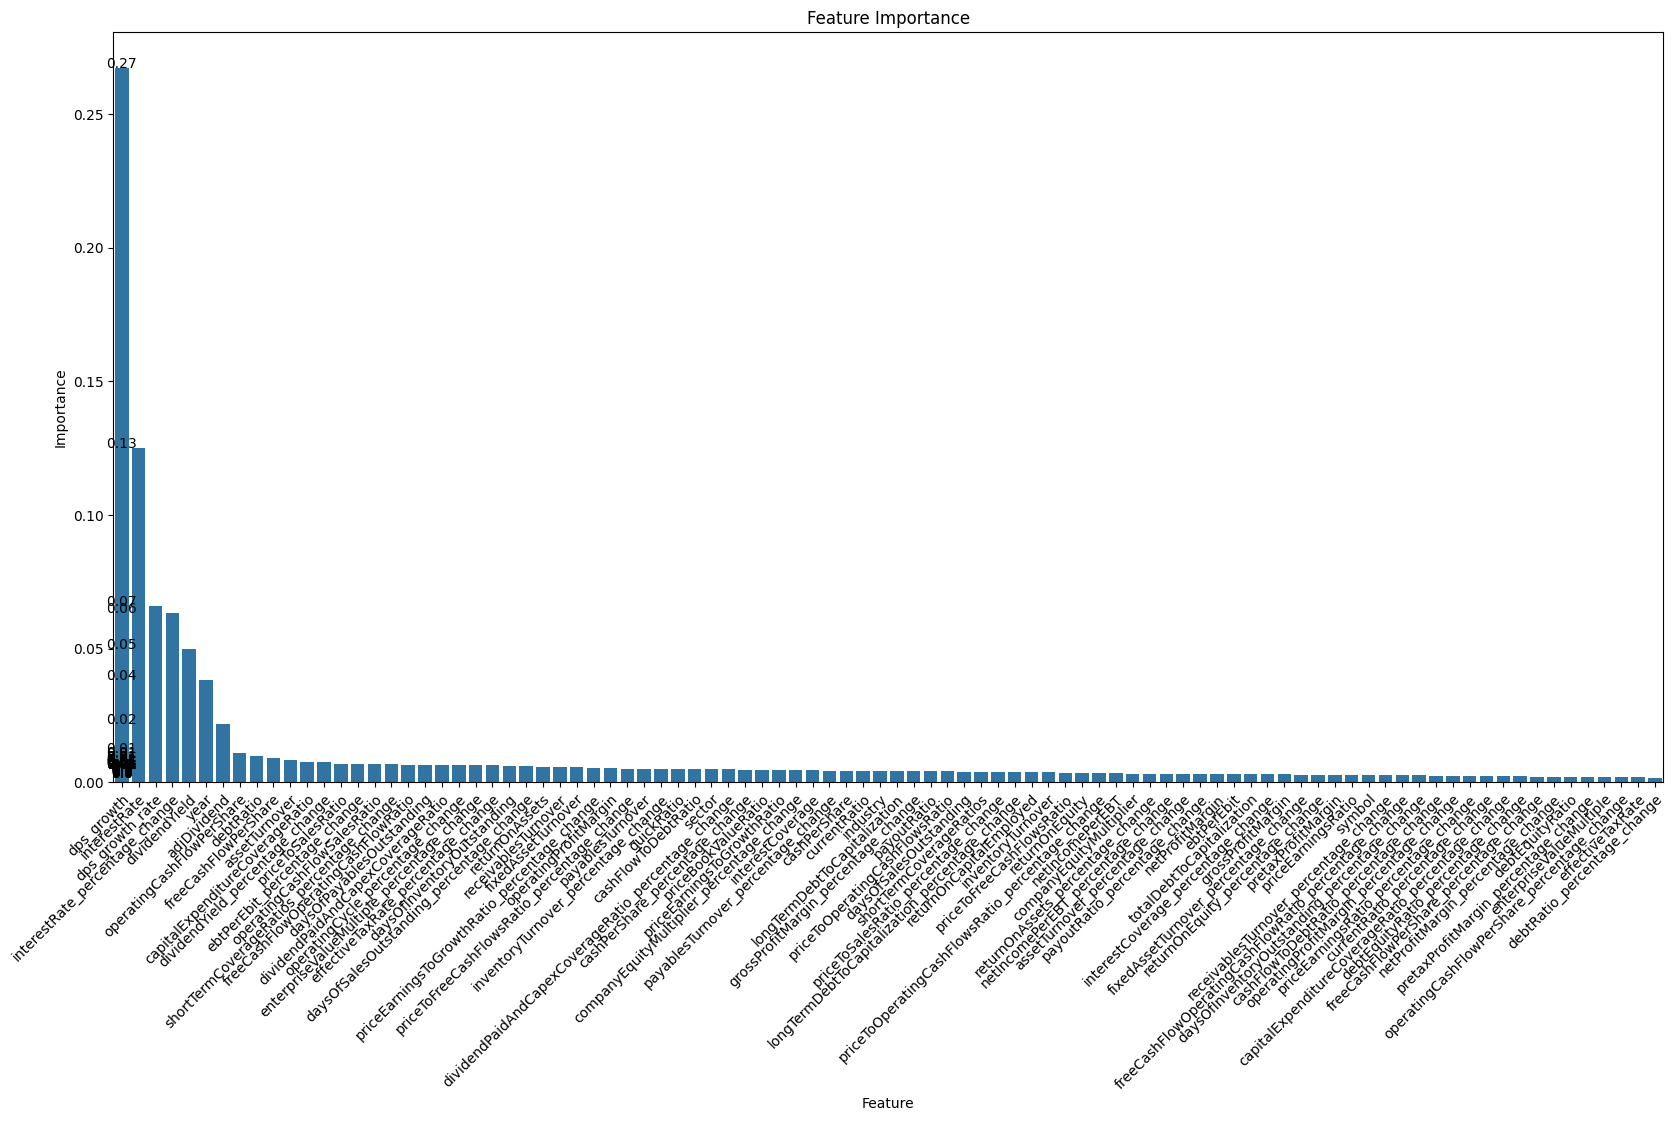

In [29]:
# Plot a bar chart to visualize feature importance
plt.figure(figsize=(20, 10))
barplot = sns.barplot(data=importance_table, x="Feature", y="Importance")

# Annotate each bar with its value
for index, row in importance_table.iterrows():
    barplot.text(index, row['Importance'], str(round(row['Importance'], 2)), color='black', ha="center")

plt.title("Feature Importance")
plt.subplots_adjust(bottom=0.2, top=0.95)
plt.xticks(rotation=45, ha='right', rotation_mode="anchor")
plt.savefig(PATH + "feature_importance_bkp.png")
plt.show()

In [30]:
# Now let's remove the features one by one from the least important one
X_train_temp = X_train_oversampled.copy()
X_validate_temp = X_validate_transformed.copy()

# Initialize the result dataframe
result_df = pd.DataFrame(columns=['Features_Removed', 'ROC_Score'])

# RandomForestClassifier

In [31]:
# First, evaluate performance using all features
randomForestModel = RandomForestClassifier(max_features=None)
randomForestModel.fit(X_train_temp, y_train_oversampled)

RandomForestClassifier(max_features=None)

In [22]:
# Predict probabilities on test data
y_pred_probs = randomForestModel.predict_proba(X_validate_temp)[:, 1]
print(y_pred_probs)

[0.13 0.   0.16 0.1  0.   0.05 0.03 0.15 0.14 0.3  0.07 0.03 0.09 0.08
 0.01 0.   0.   0.49 0.   0.   0.27 0.01 0.05 0.03 0.16 0.04 0.02 0.01
 0.09 0.03 0.15 0.01 0.03 0.05 0.09 0.   0.11 0.41 0.02 0.03 0.1  0.05
 0.11 0.07 0.   0.   0.08 0.07 0.07 0.03 0.01 0.19 0.01 0.   0.02 0.13
 0.01 0.06 0.01 0.02 0.18 0.13 0.05 0.01 0.07 0.63 0.11 0.11 0.01 0.09
 0.04 0.64 0.06 0.06 0.01 0.02 0.04 0.   0.09 0.07 0.04 0.25 0.08 0.06
 0.14 0.02 0.01 0.01 0.   0.1  0.04 0.04 0.01 0.55 0.01 0.22 0.   0.38
 0.   0.18 0.02 0.01 0.   0.43 0.17 0.48 0.01 0.22 0.04 0.02 0.26 0.05
 0.   0.   0.01 0.01 0.02 0.01 0.07 0.08 0.03 0.14 0.04 0.   0.01 0.01
 0.26 0.34 0.11 0.01 0.04 0.   0.   0.42 0.   0.   0.27 0.14 0.63 0.04
 0.06 0.1  0.03 0.01 0.   0.44 0.11 0.01 0.1  0.3  0.06 0.04 0.02 0.37
 0.05 0.   0.17 0.01 0.17 0.12 0.11 0.01 0.13 0.13 0.6  0.   0.19 0.01
 0.21 0.03 0.34 0.32 0.04 0.01 0.   0.09 0.07 0.07 0.02 0.3  0.28 0.04
 0.02 0.12 0.2  0.18 0.1  0.13 0.02 0.03 0.02 0.01 0.01 0.53 0.   0.05
 0.04 

In [23]:
# Compute ROC score
roc_score = roc_auc_score(y_test, y_pred_probs)

In [25]:
# Create a new dataframe with the new row
new_row = pd.DataFrame([{'Features_Removed': 'None', 'ROC_Score': roc_score}])

# Append the new row to the result dataframe using pd.concat
result_df = pd.concat([result_df, new_row], ignore_index=True)

print(f"Feature_Removed: None, Number of features used: {len(X_train_temp.columns)}, ROC_AUC_Score: {roc_score}")

Feature_Removed: None, Number of features used: 92, ROC_AUC_Score: 0.6837454212454213


In [26]:
# Sort importance_table by Importance in ascending order to start with the least important
importance_table_sorted = importance_table.sort_values('Importance')

# Loop through features, starting from the least important
for index, row in importance_table_sorted.iterrows():
    # Drop the feature from training and test data
    X_train_temp = X_train_temp.drop(columns=[row['Feature']])
    X_validate_temp = X_validate_temp.drop(columns=[row['Feature']])
    # Train a random forest model
    randomForestModel = RandomForestClassifier(max_features=None)
    randomForestModel.fit(X_train_temp, y_train_oversampled)
    # Predict probabilities on test data
    y_pred_probs = randomForestModel.predict_proba(X_validate_temp)[:, 1]
    # Compute ROC score
    roc_score = roc_auc_score(y_test, y_pred_probs)
    # Create a new dataframe with the new row
    new_row = pd.DataFrame([{'Features_Removed': 'None', 'ROC_Score': roc_score}])
    # Append the new row to the result dataframe using pd.concat
    result_df = pd.concat([result_df, new_row], ignore_index=True)
    print(
        f"Feature_Removed: {row['Feature']}, Number of features used: {len(X_train_temp.columns)}, ROC_AUC_Score: {roc_score}")
    # If only one feature left, break the loop
    if X_train_temp.shape[1] == 1:
        break

Feature_Removed: effectiveTaxRate, Number of features used: 91, ROC_AUC_Score: 0.7423992673992673
Feature_Removed: enterpriseValueMultiple, Number of features used: 90, ROC_AUC_Score: 0.7154761904761905
Feature_Removed: capitalExpenditureCoverageRatio_percentage_change, Number of features used: 89, ROC_AUC_Score: 0.7415750915750916
Feature_Removed: netProfitMargin_percentage_change, Number of features used: 88, ROC_AUC_Score: 0.7085164835164836
Feature_Removed: operatingCashFlowPerShare_percentage_change, Number of features used: 87, ROC_AUC_Score: 0.7273351648351648
Feature_Removed: returnOnAssets_percentage_change, Number of features used: 86, ROC_AUC_Score: 0.7458333333333332
Feature_Removed: debtEquityRatio, Number of features used: 85, ROC_AUC_Score: 0.7228021978021978
Feature_Removed: freeCashFlowPerShare_percentage_change, Number of features used: 84, ROC_AUC_Score: 0.7311355311355311
Feature_Removed: pretaxProfitMargin_percentage_change, Number of features used: 83, ROC_AUC_Sco

KeyboardInterrupt: 

In [32]:
y_pred_rf = randomForestModel.predict(X_test_transformed)

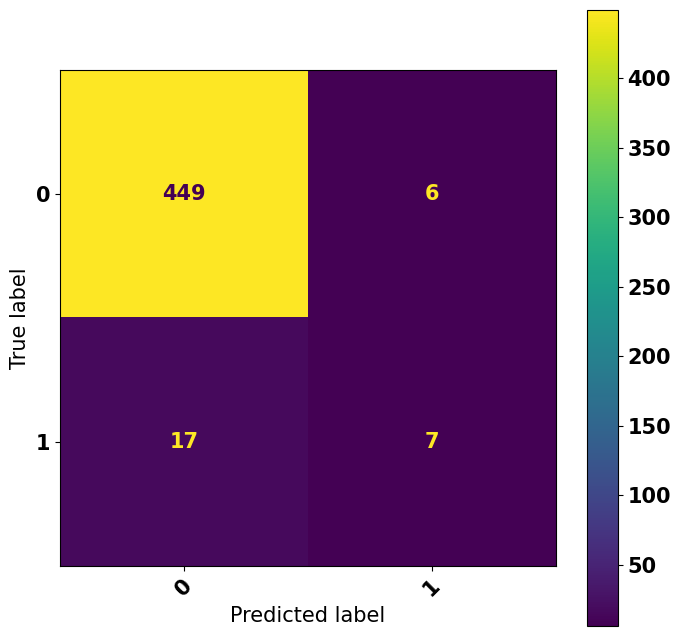

In [33]:
# Generating confusion matrics for Random Forest Classifier
from sklearn.metrics import confusion_matrix,f1_score,precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay

font = {
    'weight' : 'bold',
    'size'   : 15}
plt.rc('font', **font)

cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= [0, 1])
disp.plot(xticks_rotation=45)
fig = disp.ax_.get_figure()
fig.set_figwidth(8)
fig.set_figheight(8)
fig.savefig(PATH + 'random_forest_confusion_matrix.png')
plt.show()

In [35]:
Metrics = pd.DataFrame({"Accuracy":[accuracy_score(y_test, y_pred_rf, normalize=True)]
,"Precision":[precision_score(y_test, y_pred_rf, average = 'macro')]
,"Recall":[recall_score(y_test, y_pred_rf, average = 'macro')]
,"F1-Score":[f1_score(y_test, y_pred_rf, average = 'macro')]})

Metrics

,Accuracy,Precision,Recall,F1-Score
0,0.951983,0.75099,0.63924,0.676703


# DecisionTreeClassifier

In [40]:
# Decision Tree
def objective_function(trial):
    max_depth = trial.suggest_int('max_depth', 1, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion
    )

    # Using cross_val_score to get the average precision score for each fold
    scores = cross_val_score(model, X_train_oversampled, y_train_oversampled, cv=5, scoring='roc_auc')
    roc_auc = np.mean(scores)
    # Printing intermediate results
    print(f"Trial {trial.number}, max_depth: {max_depth}, min_samples_split: {min_samples_split}, "
          f"min_samples_leaf: {min_samples_leaf}, criterion: {criterion}, ROC-AUC: {roc_auc}")
    return roc_auc

study_dt = optuna.create_study(direction="maximize")
study_dt.optimize(objective_function, n_trials=20)

best_params_dt = study_dt.best_params
print("Best Parameters: ", best_params_dt)
print("Best ROC-AUC Score: ", study_dt.best_value)

[I 2024-05-19 08:31:41,870] A new study created in memory with name: no-name-065351cf-5de0-4d77-9270-2678ad6df991
[I 2024-05-19 08:31:47,635] Trial 0 finished with value: 0.8710719403295666 and parameters: {'max_depth': 40, 'min_samples_split': 5, 'min_samples_leaf': 15, 'criterion': 'gini'}. Best is trial 0 with value: 0.8710719403295666.


Trial 0, max_depth: 40, min_samples_split: 5, min_samples_leaf: 15, criterion: gini, ROC-AUC: 0.8710719403295666


[I 2024-05-19 08:31:49,463] Trial 1 finished with value: 0.788471264526864 and parameters: {'max_depth': 4, 'min_samples_split': 13, 'min_samples_leaf': 4, 'criterion': 'gini'}. Best is trial 0 with value: 0.8710719403295666.


Trial 1, max_depth: 4, min_samples_split: 13, min_samples_leaf: 4, criterion: gini, ROC-AUC: 0.788471264526864


[I 2024-05-19 08:31:54,432] Trial 2 finished with value: 0.8730396675967862 and parameters: {'max_depth': 11, 'min_samples_split': 11, 'min_samples_leaf': 4, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8730396675967862.


Trial 2, max_depth: 11, min_samples_split: 11, min_samples_leaf: 4, criterion: entropy, ROC-AUC: 0.8730396675967862


[I 2024-05-19 08:31:57,946] Trial 3 finished with value: 0.8676433858457602 and parameters: {'max_depth': 24, 'min_samples_split': 8, 'min_samples_leaf': 11, 'criterion': 'gini'}. Best is trial 2 with value: 0.8730396675967862.


Trial 3, max_depth: 24, min_samples_split: 8, min_samples_leaf: 11, criterion: gini, ROC-AUC: 0.8676433858457602


[I 2024-05-19 08:32:01,659] Trial 4 finished with value: 0.8442393415694361 and parameters: {'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 2 with value: 0.8730396675967862.


Trial 4, max_depth: 19, min_samples_split: 4, min_samples_leaf: 8, criterion: gini, ROC-AUC: 0.8442393415694361


[I 2024-05-19 08:32:05,874] Trial 5 finished with value: 0.8864972118473359 and parameters: {'max_depth': 38, 'min_samples_split': 4, 'min_samples_leaf': 11, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8864972118473359.


Trial 5, max_depth: 38, min_samples_split: 4, min_samples_leaf: 11, criterion: entropy, ROC-AUC: 0.8864972118473359


[I 2024-05-19 08:32:10,416] Trial 6 finished with value: 0.8683204735790706 and parameters: {'max_depth': 26, 'min_samples_split': 10, 'min_samples_leaf': 4, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8864972118473359.


Trial 6, max_depth: 26, min_samples_split: 10, min_samples_leaf: 4, criterion: entropy, ROC-AUC: 0.8683204735790706


[I 2024-05-19 08:32:14,520] Trial 7 finished with value: 0.8340221119442403 and parameters: {'max_depth': 46, 'min_samples_split': 7, 'min_samples_leaf': 5, 'criterion': 'gini'}. Best is trial 5 with value: 0.8864972118473359.


Trial 7, max_depth: 46, min_samples_split: 7, min_samples_leaf: 5, criterion: gini, ROC-AUC: 0.8340221119442403


[I 2024-05-19 08:32:18,342] Trial 8 finished with value: 0.8618083006486941 and parameters: {'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8864972118473359.


Trial 8, max_depth: 19, min_samples_split: 3, min_samples_leaf: 2, criterion: entropy, ROC-AUC: 0.8618083006486941


[I 2024-05-19 08:32:23,022] Trial 9 finished with value: 0.8735431262980395 and parameters: {'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 14, 'criterion': 'gini'}. Best is trial 5 with value: 0.8864972118473359.


Trial 9, max_depth: 18, min_samples_split: 10, min_samples_leaf: 14, criterion: gini, ROC-AUC: 0.8735431262980395


[I 2024-05-19 08:32:26,820] Trial 10 finished with value: 0.884000597573617 and parameters: {'max_depth': 34, 'min_samples_split': 15, 'min_samples_leaf': 10, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8864972118473359.


Trial 10, max_depth: 34, min_samples_split: 15, min_samples_leaf: 10, criterion: entropy, ROC-AUC: 0.884000597573617


[I 2024-05-19 08:32:30,472] Trial 11 finished with value: 0.880778158861089 and parameters: {'max_depth': 36, 'min_samples_split': 14, 'min_samples_leaf': 10, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8864972118473359.


Trial 11, max_depth: 36, min_samples_split: 14, min_samples_leaf: 10, criterion: entropy, ROC-AUC: 0.880778158861089


[I 2024-05-19 08:32:34,320] Trial 12 finished with value: 0.882119062888636 and parameters: {'max_depth': 35, 'min_samples_split': 2, 'min_samples_leaf': 12, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8864972118473359.


Trial 12, max_depth: 35, min_samples_split: 2, min_samples_leaf: 12, criterion: entropy, ROC-AUC: 0.882119062888636


[I 2024-05-19 08:32:39,393] Trial 13 finished with value: 0.8801154993584239 and parameters: {'max_depth': 46, 'min_samples_split': 15, 'min_samples_leaf': 8, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8864972118473359.


Trial 13, max_depth: 46, min_samples_split: 15, min_samples_leaf: 8, criterion: entropy, ROC-AUC: 0.8801154993584239


[I 2024-05-19 08:32:43,048] Trial 14 finished with value: 0.8858619469844957 and parameters: {'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 9, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8864972118473359.


Trial 14, max_depth: 30, min_samples_split: 6, min_samples_leaf: 9, criterion: entropy, ROC-AUC: 0.8858619469844957


[I 2024-05-19 08:32:46,759] Trial 15 finished with value: 0.8797001095954469 and parameters: {'max_depth': 29, 'min_samples_split': 6, 'min_samples_leaf': 7, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8864972118473359.


Trial 15, max_depth: 29, min_samples_split: 6, min_samples_leaf: 7, criterion: entropy, ROC-AUC: 0.8797001095954469


[I 2024-05-19 08:32:51,162] Trial 16 finished with value: 0.8853893960441865 and parameters: {'max_depth': 50, 'min_samples_split': 5, 'min_samples_leaf': 13, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8864972118473359.


Trial 16, max_depth: 50, min_samples_split: 5, min_samples_leaf: 13, criterion: entropy, ROC-AUC: 0.8853893960441865


[I 2024-05-19 08:32:55,638] Trial 17 finished with value: 0.8804572528995045 and parameters: {'max_depth': 42, 'min_samples_split': 2, 'min_samples_leaf': 10, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8864972118473359.


Trial 17, max_depth: 42, min_samples_split: 2, min_samples_leaf: 10, criterion: entropy, ROC-AUC: 0.8804572528995045


[I 2024-05-19 08:32:59,369] Trial 18 finished with value: 0.8762256647361335 and parameters: {'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 7, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8864972118473359.


Trial 18, max_depth: 30, min_samples_split: 7, min_samples_leaf: 7, criterion: entropy, ROC-AUC: 0.8762256647361335


[I 2024-05-19 08:33:03,091] Trial 19 finished with value: 0.8781576246095671 and parameters: {'max_depth': 41, 'min_samples_split': 4, 'min_samples_leaf': 9, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8864972118473359.


Trial 19, max_depth: 41, min_samples_split: 4, min_samples_leaf: 9, criterion: entropy, ROC-AUC: 0.8781576246095671
Best Parameters:  {'max_depth': 38, 'min_samples_split': 4, 'min_samples_leaf': 11, 'criterion': 'entropy'}
Best ROC-AUC Score:  0.8864972118473359


In [48]:
# higher accuracy 91%: default max_depth None, min_samples_split 2, min_samples_leaf 1
entropy_tree = DecisionTreeClassifier(criterion='entropy')

# best trial, but lower accuracy 89%
# entropy_tree = DecisionTreeClassifier(max_depth=38, min_samples_split=4, min_samples_leaf=11, criterion='entropy')

entropy_tree.fit(X_train_temp, y_train_oversampled)
y_pred_dt = entropy_tree.predict(X_test_transformed)

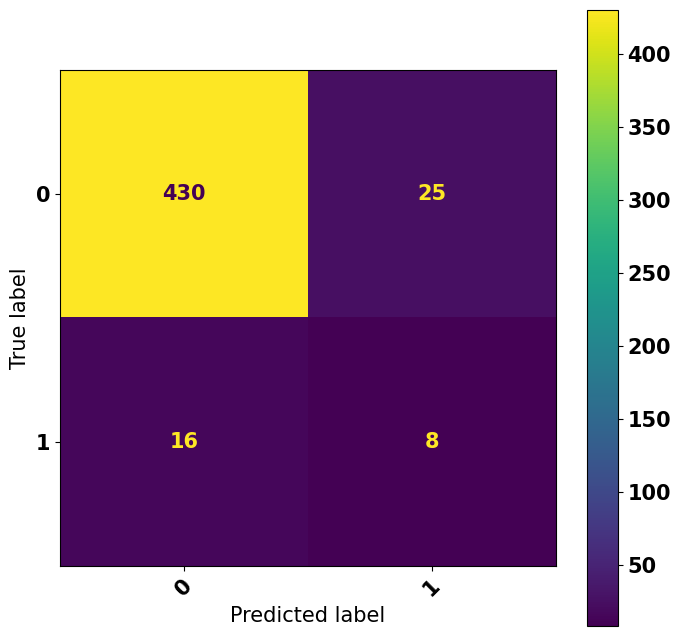

In [49]:
# Generating confusion matrics for Decision Tree Classifier

plt.rc('font', **font)

cm = confusion_matrix(y_test, y_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= [0, 1])
disp.plot(xticks_rotation=45)
fig = disp.ax_.get_figure()
fig.set_figwidth(8)
fig.set_figheight(8)
fig.savefig(PATH + 'decision_tree_confusion_matrix.png')
plt.show()

In [50]:
Metrics = pd.DataFrame({"Accuracy":[accuracy_score(y_test, y_pred_dt, normalize=True)]
,"Precision":[precision_score(y_test, y_pred_dt, average = 'macro')]
,"Recall":[recall_score(y_test, y_pred_dt, average = 'macro')]
,"F1-Score":[f1_score(y_test, y_pred_dt, average = 'macro')]})

Metrics

,Accuracy,Precision,Recall,F1-Score
0,0.914405,0.603275,0.639194,0.617598


# KNeighborsClassifier

In [52]:
# KNN
def objective_function(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 30)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    p = trial.suggest_int('p', 1, 5)
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])

    model = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        p=p,
        metric=metric
    )

    # Using cross_val_score to get the average precision score for each fold
    scores = cross_val_score(model, X_train_oversampled, y_train_oversampled, cv=5, scoring='roc_auc')
    roc_auc = np.mean(scores)
    # Printing intermediate results
    print(f"Trial {trial.number}, n_neighbors: {n_neighbors}, weights: {weights}, p: {p}, metric: {metric}, "
          f"ROC-AUC: {roc_auc}")
    return roc_auc


study_knn = optuna.create_study(direction="maximize")
study_knn.optimize(objective_function, n_trials=20)

best_params_knn = study_knn.best_params
print("Best Parameters: ", best_params_knn)
print("Best ROC-AUC Score: ", study_knn.best_value)

[I 2024-05-19 08:38:01,410] A new study created in memory with name: no-name-cc89cf98-b6b9-4a83-abea-244e96234237
[I 2024-05-19 08:40:04,070] Trial 0 finished with value: 0.7925406005344122 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'p': 5, 'metric': 'minkowski'}. Best is trial 0 with value: 0.7925406005344122.


Trial 0, n_neighbors: 23, weights: uniform, p: 5, metric: minkowski, ROC-AUC: 0.7925406005344122


[I 2024-05-19 08:40:15,948] Trial 1 finished with value: 0.9647934575035094 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'p': 3, 'metric': 'manhattan'}. Best is trial 1 with value: 0.9647934575035094.


Trial 1, n_neighbors: 20, weights: distance, p: 3, metric: manhattan, ROC-AUC: 0.9647934575035094


[I 2024-05-19 08:41:51,878] Trial 2 finished with value: 0.8914081720379581 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'p': 4, 'metric': 'minkowski'}. Best is trial 1 with value: 0.9647934575035094.


Trial 2, n_neighbors: 15, weights: distance, p: 4, metric: minkowski, ROC-AUC: 0.8914081720379581


[I 2024-05-19 08:42:00,234] Trial 3 finished with value: 0.9601486778505613 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'p': 3, 'metric': 'manhattan'}. Best is trial 1 with value: 0.9647934575035094.


Trial 3, n_neighbors: 9, weights: uniform, p: 3, metric: manhattan, ROC-AUC: 0.9601486778505613


[I 2024-05-19 08:42:07,167] Trial 4 finished with value: 0.9470553453628681 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'p': 1, 'metric': 'manhattan'}. Best is trial 1 with value: 0.9647934575035094.


Trial 4, n_neighbors: 4, weights: distance, p: 1, metric: manhattan, ROC-AUC: 0.9470553453628681


[I 2024-05-19 08:42:13,166] Trial 5 finished with value: 0.937107223348546 and parameters: {'n_neighbors': 19, 'weights': 'uniform', 'p': 1, 'metric': 'minkowski'}. Best is trial 1 with value: 0.9647934575035094.


Trial 5, n_neighbors: 19, weights: uniform, p: 1, metric: minkowski, ROC-AUC: 0.937107223348546


[I 2024-05-19 08:42:18,208] Trial 6 finished with value: 0.9401887089606553 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'p': 3, 'metric': 'manhattan'}. Best is trial 1 with value: 0.9647934575035094.


Trial 6, n_neighbors: 18, weights: uniform, p: 3, metric: manhattan, ROC-AUC: 0.9401887089606553


[I 2024-05-19 08:42:19,031] Trial 7 finished with value: 0.9350225366429562 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'p': 2, 'metric': 'euclidean'}. Best is trial 1 with value: 0.9647934575035094.


Trial 7, n_neighbors: 12, weights: distance, p: 2, metric: euclidean, ROC-AUC: 0.9350225366429562


[I 2024-05-19 08:42:20,066] Trial 8 finished with value: 0.9315274830035021 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'p': 1, 'metric': 'euclidean'}. Best is trial 1 with value: 0.9647934575035094.


Trial 8, n_neighbors: 14, weights: distance, p: 1, metric: euclidean, ROC-AUC: 0.9315274830035021


[I 2024-05-19 08:42:22,286] Trial 9 finished with value: 0.8676662625601074 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'p': 2, 'metric': 'euclidean'}. Best is trial 1 with value: 0.9647934575035094.


Trial 9, n_neighbors: 20, weights: uniform, p: 2, metric: euclidean, ROC-AUC: 0.8676662625601074


[I 2024-05-19 08:42:29,476] Trial 10 finished with value: 0.9498428581503756 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'p': 5, 'metric': 'manhattan'}. Best is trial 1 with value: 0.9647934575035094.


Trial 10, n_neighbors: 30, weights: distance, p: 5, metric: manhattan, ROC-AUC: 0.9498428581503756


[I 2024-05-19 08:42:43,516] Trial 11 finished with value: 0.9584481003033707 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'p': 3, 'metric': 'manhattan'}. Best is trial 1 with value: 0.9647934575035094.


Trial 11, n_neighbors: 7, weights: uniform, p: 3, metric: manhattan, ROC-AUC: 0.9584481003033707


[I 2024-05-19 08:42:52,288] Trial 12 finished with value: 0.9601486778505613 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'p': 4, 'metric': 'manhattan'}. Best is trial 1 with value: 0.9647934575035094.


Trial 12, n_neighbors: 9, weights: uniform, p: 4, metric: manhattan, ROC-AUC: 0.9601486778505613


[I 2024-05-19 08:42:58,995] Trial 13 finished with value: 0.954587606073882 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 4, 'metric': 'manhattan'}. Best is trial 1 with value: 0.9647934575035094.


Trial 13, n_neighbors: 27, weights: distance, p: 4, metric: manhattan, ROC-AUC: 0.954587606073882


[I 2024-05-19 08:43:03,980] Trial 14 finished with value: 0.8862665535712921 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'p': 2, 'metric': 'manhattan'}. Best is trial 1 with value: 0.9647934575035094.


Trial 14, n_neighbors: 1, weights: distance, p: 2, metric: manhattan, ROC-AUC: 0.8862665535712921


[I 2024-05-19 08:43:11,005] Trial 15 finished with value: 0.9600372509050944 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'p': 3, 'metric': 'manhattan'}. Best is trial 1 with value: 0.9647934575035094.


Trial 15, n_neighbors: 10, weights: uniform, p: 3, metric: manhattan, ROC-AUC: 0.9600372509050944


[I 2024-05-19 08:43:16,265] Trial 16 finished with value: 0.9199461401643818 and parameters: {'n_neighbors': 24, 'weights': 'uniform', 'p': 4, 'metric': 'manhattan'}. Best is trial 1 with value: 0.9647934575035094.


Trial 16, n_neighbors: 24, weights: uniform, p: 4, metric: manhattan, ROC-AUC: 0.9199461401643818


[I 2024-05-19 08:43:21,301] Trial 17 finished with value: 0.9598689065951179 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'p': 2, 'metric': 'manhattan'}. Best is trial 1 with value: 0.9647934575035094.


Trial 17, n_neighbors: 6, weights: distance, p: 2, metric: manhattan, ROC-AUC: 0.9598689065951179


[I 2024-05-19 08:43:23,395] Trial 18 finished with value: 0.8578922403160186 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'p': 3, 'metric': 'euclidean'}. Best is trial 1 with value: 0.9647934575035094.


Trial 18, n_neighbors: 22, weights: uniform, p: 3, metric: euclidean, ROC-AUC: 0.8578922403160186


[I 2024-05-19 08:44:53,342] Trial 19 finished with value: 0.8878636937925425 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'p': 4, 'metric': 'minkowski'}. Best is trial 1 with value: 0.9647934575035094.


Trial 19, n_neighbors: 16, weights: distance, p: 4, metric: minkowski, ROC-AUC: 0.8878636937925425
Best Parameters:  {'n_neighbors': 20, 'weights': 'distance', 'p': 3, 'metric': 'manhattan'}
Best ROC-AUC Score:  0.9647934575035094


In [63]:
# default n_neighbors 5, weights uniform, p 2, metric minkowski, 79%
knn = KNeighborsClassifier()
# best trial: 73% accuracy
# knn = KNeighborsClassifier(n_neighbors=20, weights='distance', p=3, metric='manhattan')

knn.fit(X_train_temp, y_train_oversampled)
y_pred_knn = knn.predict(X_test_transformed)

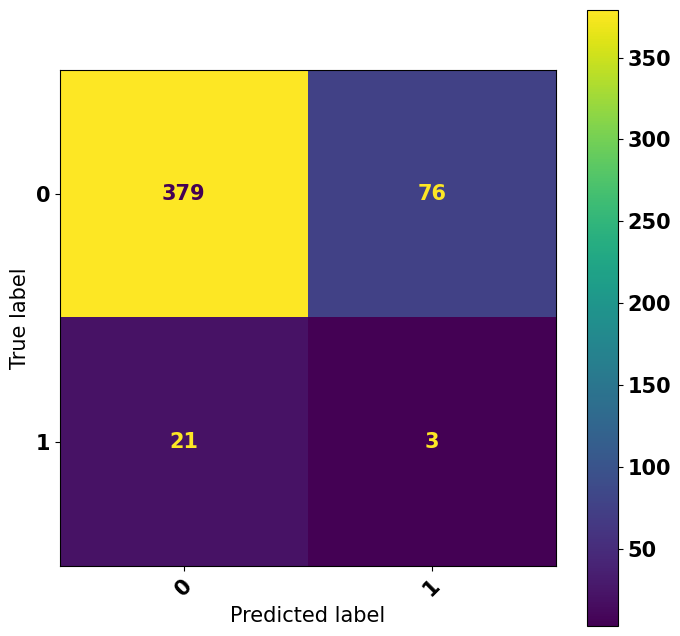

In [64]:
# Generating confusion matrics for KNeighborsClassifier

plt.rc('font', **font)

cm = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= [0, 1])
disp.plot(xticks_rotation=45)
fig = disp.ax_.get_figure()
fig.set_figwidth(8)
fig.set_figheight(8)
fig.savefig(PATH + 'knn_confusion_matrix.png')
plt.show()

In [65]:
Metrics = pd.DataFrame({"Accuracy":[accuracy_score(y_test, y_pred_knn, normalize=True)]
,"Precision":[precision_score(y_test, y_pred_knn, average = 'macro')]
,"Recall":[recall_score(y_test, y_pred_knn, average = 'macro')]
,"F1-Score":[f1_score(y_test, y_pred_knn, average = 'macro')]})

Metrics

,Accuracy,Precision,Recall,F1-Score
0,0.797495,0.492737,0.478984,0.472401


Draw ROC-AUC graph with default classifier


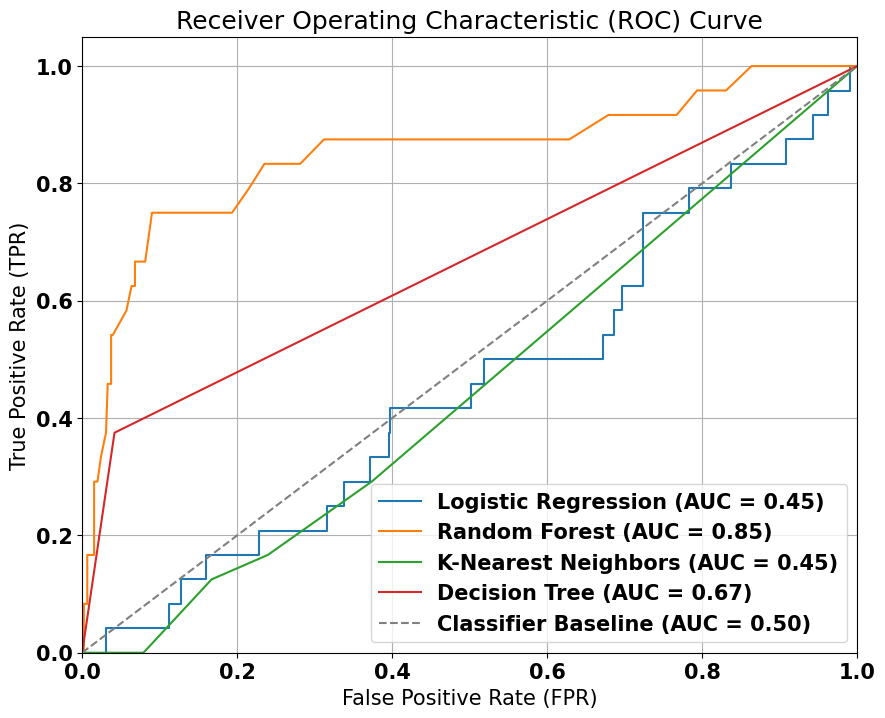

In [77]:
from sklearn.metrics import roc_curve, auc

# Define classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree':DecisionTreeClassifier(criterion='entropy')
}

# Initialize figure for ROC curve
plt.figure(figsize=(10, 8))

# Iterate over classifiers
for name, clf in classifiers.items():
    # Train classifier
    clf.fit(X_train_temp, y_train_oversampled)
    # Get predicted probabilities
    y_pred_prob = clf.predict_proba(X_test_transformed)[:, 1]
    # Assuming positive class: 1 would be decreased
    pos_label = 'decreased'
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot random classifier (baseline)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Classifier Baseline (AUC = 0.50)')

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig(PATH + "roc_curve_default.png")

# Show plot
plt.grid(True)
plt.show()

Draw ROC-AUC graph with best trial classifier


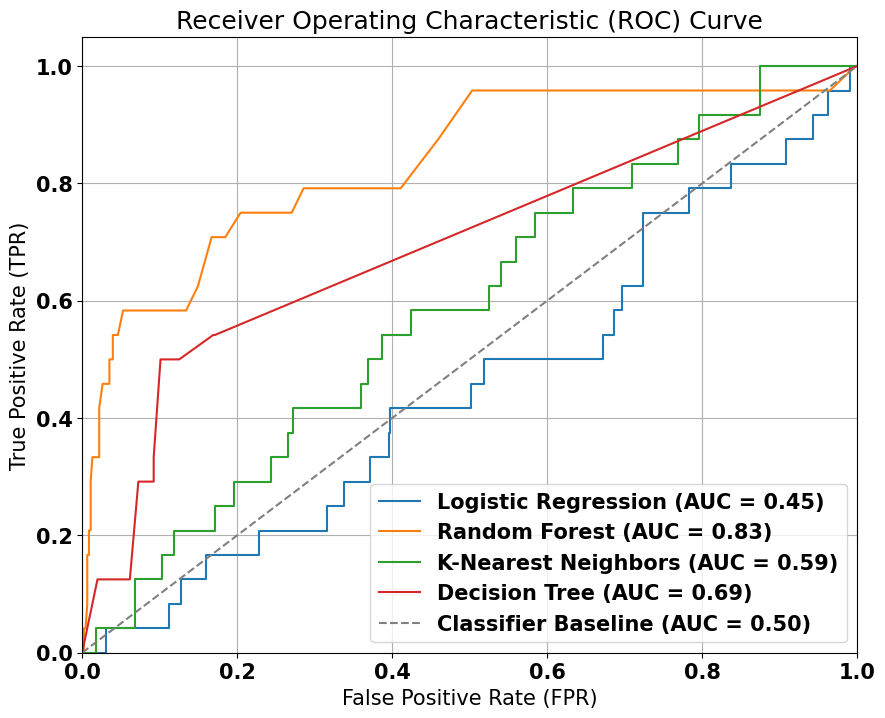

In [78]:
# Define classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(max_features=None),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=20, weights='distance', p=3, metric='manhattan'),
    'Decision Tree': DecisionTreeClassifier(max_depth=38, min_samples_split=4, min_samples_leaf=11, criterion='entropy')
}

# Initialize figure for ROC curve
plt.figure(figsize=(10, 8))

# Iterate over classifiers
for name, clf in classifiers.items():
    # Train classifier
    clf.fit(X_train_temp, y_train_oversampled)
    # Get predicted probabilities
    y_pred_prob = clf.predict_proba(X_test_transformed)[:, 1]
    # Assuming positive class: 1 would be decreased
    pos_label = 'decreased'
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot random classifier (baseline)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Classifier Baseline (AUC = 0.50)')

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig(PATH + "roc_curve_best_trial.png")

# Show plot
plt.grid(True)
plt.show()